In [1]:
from jetutils.definitions import *
from jetutils.data import *
from jetutils.jet_finding import *
from jetutils.anyspell import *
from jetutils.plots import *

%load_ext IPython.extensions.autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  102400


IPython could not be loaded!


In [2]:
def create_jet_relative_dataset(jets, path, da, suffix="", half_length: float = 20.):
    indexer = iterate_over_year_maybe_member(jets, da)
    to_average = []
    varname = da.name + "_interp"
    for idx1, idx2 in tqdm(indexer, total=len(YEARS)):
        jets_ = jets.filter(*idx1)
        da_ = da.sel(**idx2)
        try:
            jets_with_interp = gather_normal_da_jets(jets_, da_, half_length=half_length)
        except (KeyError, ValueError) as e:
            print(e)
            break
        jets_with_interp = interp_jets_to_zero_one(jets_with_interp, [varname, "is_polar"], n_interp=30)
        jets_with_interp = jets_with_interp.group_by("time", pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5, "norm_index", "n", maintain_order=True).agg(pl.col(varname).mean())
        to_average.append(jets_with_interp)
    pl.concat(to_average).write_parquet(path.joinpath(f"{da.name}{suffix}_relative.parquet"))

In [27]:
run = "ctrl"

dh = DataHandler.from_specs("Henrik_data", run, ("high_wind", ["u", "v", "s", "theta", "lev"]), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80)
exp = JetFindingExperiment(dh)
exp.find_jets(force=False, n_coarsen=1, smooth_s=5, alignment_thresh=0.55, base_s_thresh=0.55, int_thresh_factor=0.2, hole_size=5)
# jets = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=15, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})
# dh_mid = DataHandler.from_specs("Henrik_data", run, ("mid_wind", "s"), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80)
jets = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=15, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})

props_uncat = exp.props_as_df(categorize=False)
props_as_df = exp.props_as_df(force=0)

phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.5e8))

phat_jets = jets.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.5e8)))
phat_jets_catd = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)

jets_ctrl = phat_jets_catd.clone()
props_ctrl = phat_props_catd.clone()

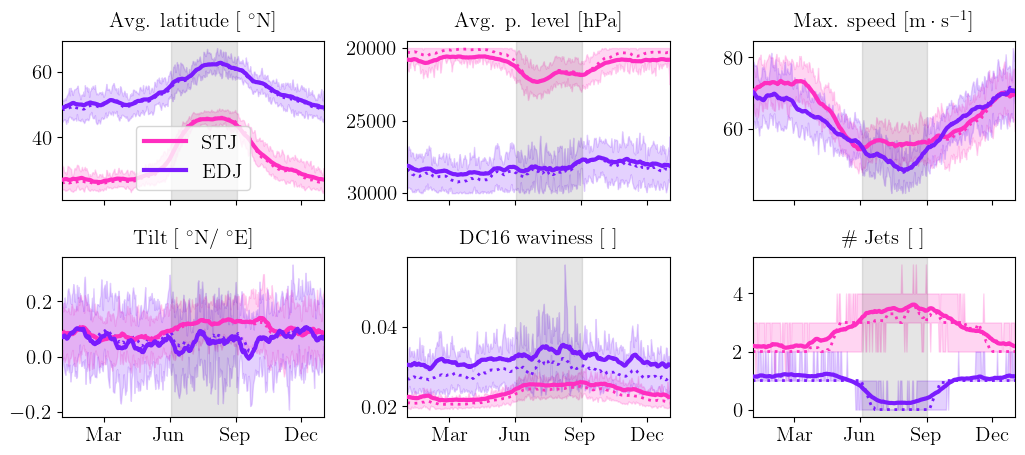

In [28]:
data_vars = [
    "mean_lat",
    "mean_lev",
    "s_star",
    "tilt",
    "wavinessDC16",
    "njets",
]
_ = plot_seasonal(
    props_ctrl, data_vars, nrows=2, ncols=3, clear=False, save=False,
)

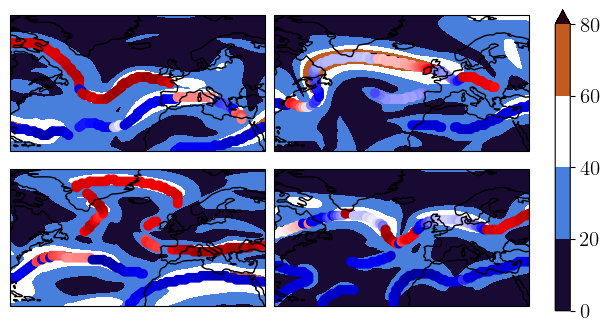

In [30]:
nx, ny = 2, 2
clu = Clusterplot(nx, ny, region=get_region(dh.da))
t = np.sort(np.atleast_1d(np.random.randint(len(dh.da.time), size=nx * ny)))
clu.add_contourf(dh.da["s"][t])
huh = pl.Series(None, dh.da.time[t].values).cast(pl.Datetime("ms")).rename("time").to_frame().join(jets_ctrl, on="time").sort("time", "jet ID")
for i, (_, jet_) in enumerate(huh.group_by("time", maintain_order=True)):
    x, y, c = jet_[["lon", "lat", "is_polar"]]
    clu.axes[i].scatter(x - clu.central_longitude, y, c=c, vmin=0, vmax=1, cmap=colormaps.BlWhRe)

In [33]:
args = ["all", None, -100, 60, 0, 90]
path = exp.path

# da = open_da("Henrik_data", run, ("high_wind", "PTTEND"), "6H", *args)
# da = compute(da)
# create_jet_relative_dataset(jets_ctrl, path, da)
# del da

da = open_da("Henrik_data", run, ("high_wind", "DTCOND"), "6H", *args)
da = compute(da)
create_jet_relative_dataset(jets_ctrl, path, da)
del da

da = open_da("Henrik_data", run, ("high_wind", "theta"), "6H", *args)
da = compute(da)
create_jet_relative_dataset(jets_ctrl, path, da)
del da

da = open_da("Henrik_data", run, "z", "6H", *args)
da = compute(da)
create_jet_relative_dataset(jets_ctrl, path, da)
del da

 59%|█████▉    | 38/64 [11:20<07:45, 17.91s/it]


KeyboardInterrupt: 

In [ ]:
run = "dobl"

dh = DataHandler.from_specs("Henrik_data", run, ("high_wind", ["u", "v", "s", "theta", "lev"]), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80)
exp = JetFindingExperiment(dh)
exp.find_jets(force=True, n_coarsen=1, smooth_s=5, alignment_thresh=0.55, base_s_thresh=0.55, int_thresh_factor=0.2, hole_size=5)
# jets = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=15, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})
# dh_mid = DataHandler.from_specs("Henrik_data", run, ("mid_wind", "s"), "6H", minlon=-80, maxlon=40, minlat=15, maxlat=80)
jets = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=15, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})

props_as_df = exp.props_as_df(force=2)
props_uncat = exp.props_as_df(categorize=False)

phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.5e8))

phat_jets = jets.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.5e8)))
phat_jets_catd = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)

jets_dobl = phat_jets_catd.clone()
props_dobl = phat_props_catd.clone()

[########################################] | 100% Completed | 102.25 s


100%|██████████| 52/52 [04:41<00:00,  5.41s/it]


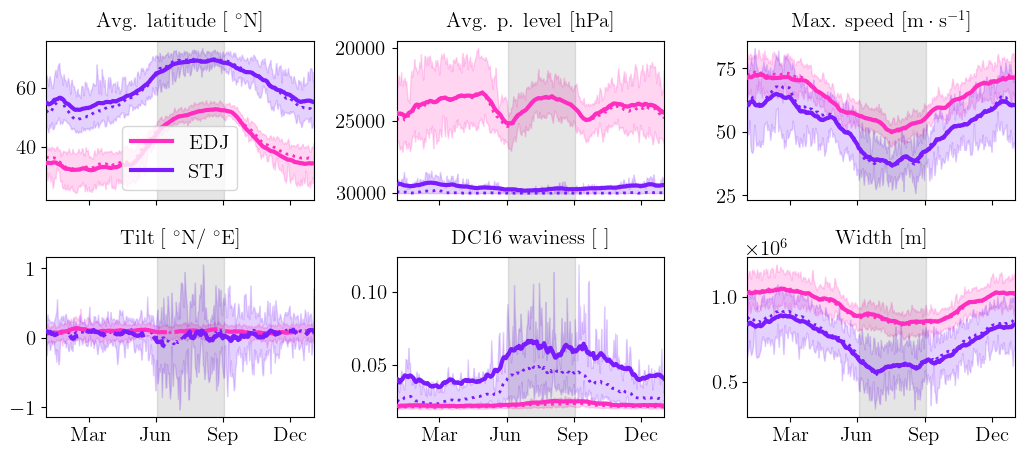

In [13]:
data_vars = [
    "mean_lat",
    "mean_lev",
    "s_star",
    "tilt",
    "wavinessDC16",
    "width",
]
_ = plot_seasonal(
    props_as_df, data_vars, nrows=2, ncols=3, clear=False, save=False,
)

100%|██████████| 12/12 [00:29<00:00,  2.45s/it]


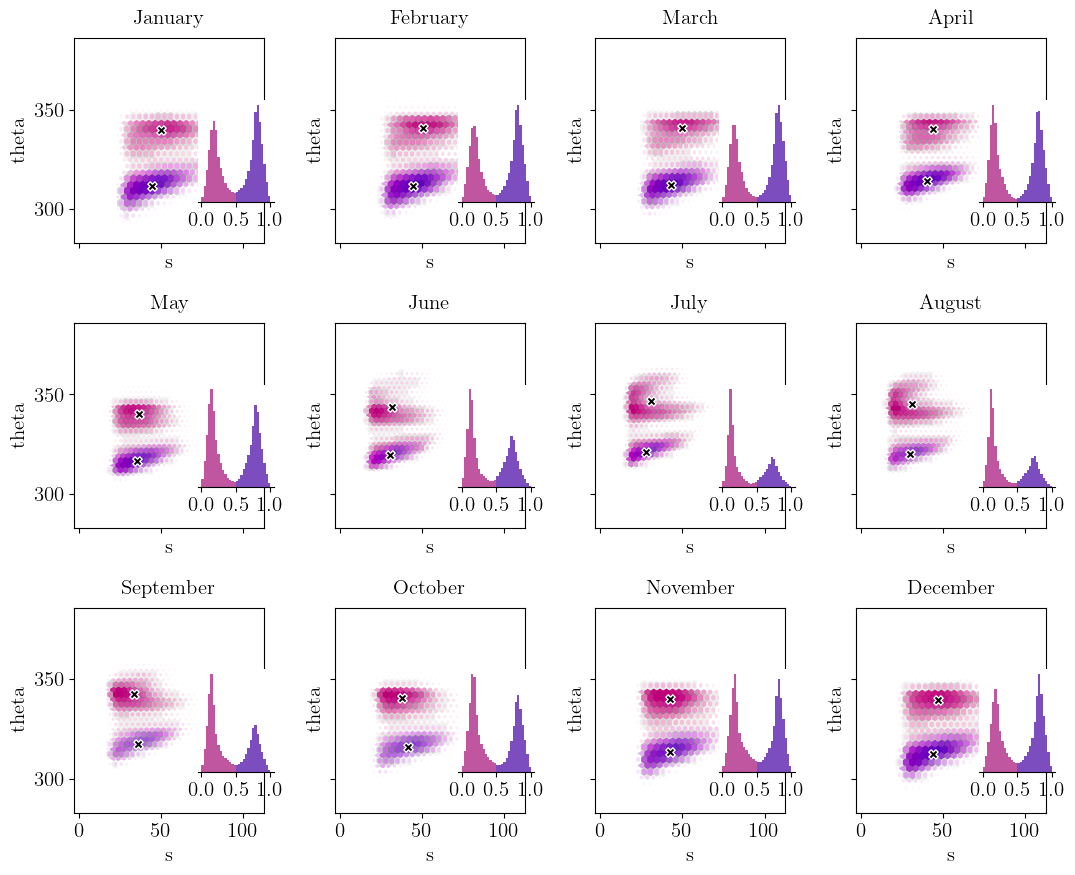

In [42]:
xys = []
all_jets = jets

xys = np.array(xys)
fig, axes = plt.subplots(3, 4, figsize=(11, 9), tight_layout=True, sharex="all", sharey="all")
axes = axes.ravel()
pair = ["s", "theta", "is_polar"]
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
bins = np.linspace(0, 1, 31)
for month in trange(1, 13):
    ax = axes[month - 1]
    X = extract_features(all_jets, pair, season=month)
    probas = X[pair[2]]
    center_stj = X.filter(pl.col("is_polar") < 0.3).mean()
    center_edj = X.filter(pl.col("is_polar") > 0.7).mean()
    X1D = X["is_polar"]
    
    im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
    im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=probas, cmap=colormaps.gray_r, gridsize=25)
    
    plt.draw()
        
    offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
    offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
    mask12 = np.isin(offsets1, offsets2)
    colors = cmap(im2.get_array())
    colors = rgb_to_hsv(colors[:, :3])
    min_s, max_s = 0., 1.0
    min_v, max_v = 0.75, 1.
    scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
    f = lambda x: np.sqrt(x)
    colors[:, 1] = min_s + scaling * (max_s - min_s)
    colors[:, 2] = max_v - scaling * (max_v - min_v)
    colors = hsv_to_rgb(colors)
    im2.set_array(None)
    im2.set_facecolor(colors)
    # im2.set_linewidths(0.2)
    im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
    im2.set_edgecolor(colormaps.greys(scaling))
    im2 = ax.add_collection(im2)
        
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
        
    ax.set_title(MONTH_NAMES[month - 1])
    ax.scatter(*pl.concat([center_stj, center_edj])[pair[:2]].to_numpy().T, facecolor="black", edgecolor="white", marker="X", linewidths=1, s=45)
    iax = ax.inset_axes([0.65, 0.2, 0.4, 0.5])
    X1D = np.clip(X1D, 0, 1)
    iax.hist(X1D, bins=bins, alpha=0.5, color="black")
    iax.hist(X1D[probas > 0.5], bins=bins, alpha=0.5, color=COLORS[1])
    iax.hist(X1D[probas < 0.5], bins=bins, alpha=0.5, color=COLORS[2])
    iax.set_xticks([0, 0.5, 1])
    iax.set_yticks([])
    iax.spines[["left", "right", "top"]].set_visible(False)
    plt.draw()
# fig.savefig(f"{FIGURES}/jet_detection_demo/gmix_demo")